In [10]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import math
import matplotlib.pyplot as plt

In [3]:
# Create a dataloader for data set
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = pd.read_csv(csv_file)
        # Shape (Batch_size, channel, x, y)
        self.X = np.array(data.iloc[:,1:]).reshape(-1,1,28, 28)
        self.Y = np.array(data.iloc[:,0])
        
        del data
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        item = self.X[idx]
        label = self.Y[idx]
        # Check if there should be a transform
        if self.transform:
            item = self.transform(item)
        return (item, label)

In [4]:
data_train = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
data_test = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

In [5]:
train_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_train.csv')
test_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_test.csv')

In [13]:
# Hyperparameters
EPOCHS = 5
BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUMBER_CLASSES = 10

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

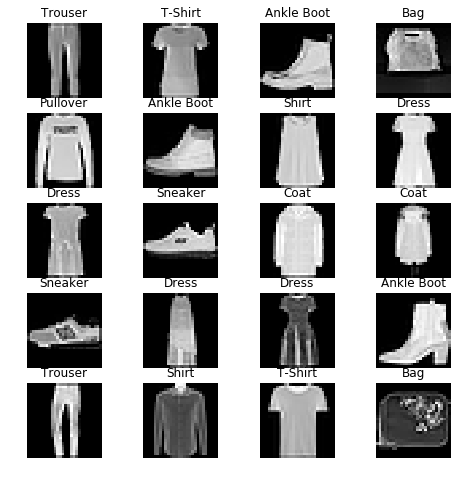

In [11]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [12]:
# Define the network
class CNN(nn.Module):
    def __init__(self, num_classes = 10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(7*7*32, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        

In [14]:
# Chose to send to gpu if it is there
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model= CNN(NUMBER_CLASSES).to(device) # Send to gpu or cpu

In [15]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [17]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    # Loop through the train loaders
    for i, (images, labels) in enumerate(train_loader):
        # Set them as varialbes
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward Pass
        outputs = model(images)
        loss = loss_function(outputs, labels)
        
        # Back prop + optimizer
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, EPOCHS, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.4222
Epoch [1/5], Step [200/600], Loss: 0.3113
Epoch [1/5], Step [300/600], Loss: 0.3149
Epoch [1/5], Step [400/600], Loss: 0.3635
Epoch [1/5], Step [500/600], Loss: 0.4254
Epoch [1/5], Step [600/600], Loss: 0.3775
Epoch [2/5], Step [100/600], Loss: 0.2122
Epoch [2/5], Step [200/600], Loss: 0.1666
Epoch [2/5], Step [300/600], Loss: 0.2730
Epoch [2/5], Step [400/600], Loss: 0.1894
Epoch [2/5], Step [500/600], Loss: 0.2914
Epoch [2/5], Step [600/600], Loss: 0.3227
Epoch [3/5], Step [100/600], Loss: 0.2517
Epoch [3/5], Step [200/600], Loss: 0.2006
Epoch [3/5], Step [300/600], Loss: 0.1889
Epoch [3/5], Step [400/600], Loss: 0.3253
Epoch [3/5], Step [500/600], Loss: 0.2557
Epoch [3/5], Step [600/600], Loss: 0.2963
Epoch [4/5], Step [100/600], Loss: 0.1557
Epoch [4/5], Step [200/600], Loss: 0.2591
Epoch [4/5], Step [300/600], Loss: 0.1665
Epoch [4/5], Step [400/600], Loss: 0.2077
Epoch [4/5], Step [500/600], Loss: 0.1737
Epoch [4/5], Step [600/600], Loss:

In [18]:
# eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.float())
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [19]:
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
torch.save(model,'FashionModel.pth')

Test Accuracy of the model on the 10000 test images: 91.28 %


C:\Users\matthew.millar\Anaconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
saved_model_path = 'FashionModel.pth'